In [ ]:
pip install mtcnn opencv-python-headless matplotlib numpy

zsh:1: no matches found: tensorflow==2.15.*
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tensorflow  # Asegura compatibilidad con MTCNN

  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached charset_normalizer-3.4.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (36 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.8.3-py3-none-any.whl.metadata (2.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.8 MB/s eta 0:00:0000:0100:06m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 1.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 2.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 3.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 3.8 MB/s eta 0:00:00a 0:00:01
   ━━━━

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN
from time import time

# Carga imagen (sube archivos en Colab o usa una URL y descárgala)
img = cv2.imread('foto-solo.jpeg')  
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

detector = MTCNN()   # puedes ajustar min_face_size
t0 = time()
res = detector.detect_faces(img_rgb)
t1 = time()

print(f"Detected: {len(res)} rostro(s) • tiempo: {(t1 - t0)*1000:.1f} ms")
for r in res:
    print(r['confidence'], r['box'], r['keypoints'].keys())

Detected: 1 rostro(s) • tiempo: 176.2 ms
0.9998483657836914 [56, 44, 67, 83] dict_keys(['nose', 'mouth_right', 'right_eye', 'left_eye', 'mouth_left'])


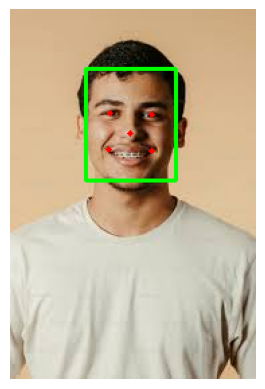

In [10]:
vis = img_rgb.copy()
for r in res:
    x, y, w, h = r['box']
    cv2.rectangle(vis, (x,y), (x+w, y+h), (0,255,0), 2)
    for name, (px,py) in r['keypoints'].items():
        cv2.circle(vis, (px,py), 2, (255,0,0), -1)
plt.imshow(vis)
plt.axis('off')
plt.show()

In [11]:
detector = MTCNN()  # su NMS interno filtra solapes
# Prueba filtrado por confianza mínima
thr = 0.90
filtrados = [r for r in res if r['confidence'] >= thr]
print(f"Con thr={thr} quedan {len(filtrados)} rostros")

Con thr=0.9 quedan 1 rostros


In [14]:
def iou(a, b):
    # a,b en formato [x,y,w,h]
    ax1, ay1, aw, ah = a; ax2, ay2 = ax1+aw, ay1+ah
    bx1, by1, bw, bh = b; bx2, by2 = bx1+bw, by1+bh
    ix1, iy1 = max(ax1,bx1), max(ay1,by1)
    ix2, iy2 = min(ax2,bx2), min(ay2,by2)
    inter = max(0, ix2-ix1)*max(0, iy2-iy1)
    union = aw*ah + bw*bh - inter
    return inter/union if union>0 else 0.0

gt_box = [125, 418, 626, 3]

# Si tienes una caja "ground truth" gt_box, compara:
print(iou(res[0]['box'], gt_box))

0.0


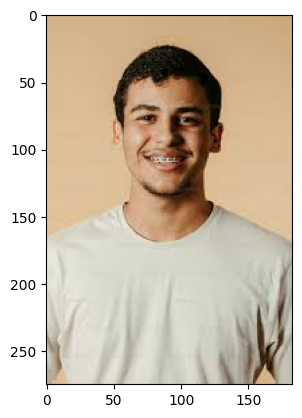

(None, (275, 183, 3))

In [15]:
import cv2
import matplotlib.pyplot as plt

# Ruta de la imagen subida
img_path = "foto-solo.jpeg"

# Cargar imagen
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Mostrar para definir caja ground truth manualmente
plt.imshow(img_rgb)
plt.axis("on")
plt.show(), img.shape

In [23]:
%matplotlib notebook


In [ ]:
import matplotlib.pyplot as plt
import cv2

# Cargar imagen
img_path = "foto-solo.jpeg"   # ajusta la ruta si es necesario
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Lista para guardar clics
points = []

def onclick(event):
    global points
    if event.xdata is not None and event.ydata is not None:
        points.append((int(event.xdata), int(event.ydata)))
        print(f"Click registrado: {points[-1]}")
        
        # Cuando ya hay dos puntos, calculamos la caja
        if len(points) == 2:
            x1, y1 = points[0]
            x2, y2 = points[1]
            w, h = abs(x2 - x1), abs(y2 - y1)
            gt_box = [min(x1, x2), min(y1, y2), w, h]
            print("✅ Tu ground truth box (gt_box) es:", gt_box)

            # Dibujar la caja
            fig, ax = plt.subplots()
            ax.imshow(img_rgb)
            rect = plt.Rectangle((gt_box[0], gt_box[1]), w, h,
                                 fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
            plt.show()

            # Desconectar evento (para no seguir registrando clics)
            fig.canvas.mpl_disconnect(cid)
            
# Mostrar imagen y activar clicks
fig, ax = plt.subplots()
ax.imshow(img_rgb)
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

<IPython.core.display.Javascript object>